## Import Libraries

In [1]:
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import time
import math

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Using TensorFlow backend.
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bulld\.conda\envs\myenv\lib\site-packages\tenso

## Load Processed Data

df = pd.read_csv("processed_batch_df_individuals_over_5_pics.csv")

df.head()

# Examine the data
df.shape

## Split Training and Test Data
### For every five samples for an individual (same ID), one sample is for testing while the other four are for training

df_arr = np.array(df)

training_data_dict = dict()
testing_data_dict = dict()

# Initialize columns
for col in tqdm(df.columns):
    training_data_dict[col] = list()
    testing_data_dict[col] = list()

temp_id = ""
    
for i in tqdm(range(df.shape[0])):
    curr_id = df_arr[i][3]
    
    if temp_id != curr_id:
        # Different ID, add to testing_data
        j = 0
        for col in df.columns:
            testing_data_dict[col].append(df_arr[i][j])
            j = j+1
        
        temp_id = curr_id
    else:
        # Same ID, add to training_data
        j = 0
        for col in df.columns:
            training_data_dict[col].append(df_arr[i][j])
            j = j+1
        
# Release memory of df_arr
df_arr = None  
    
training_data = pd.DataFrame(training_data_dict)
testing_data = pd.DataFrame(testing_data_dict)

training_data.to_csv('train_data.csv')
testing_data.to_csv('test_data.csv')

## Divide the Training and Test Data Into Features, Species Labels, and IDs

# Divide into features, ids, and species
test_features = testing_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
test_labels = testing_data['species']
test_ids = testing_data['individual_id']

test_labels.to_csv('test_labels.csv')
test_features.to_csv('test_features.csv')
test_ids.to_csv('test_ids.csv')

train_features = training_data.drop(columns=['index', 'image','species','individual_id','aspect_ratio'])
train_labels = training_data['species']
train_ids = training_data['individual_id']

train_labels.to_csv('train_labels.csv')
train_features.to_csv('train_features.csv')
train_ids.to_csv('train_ids.csv')

## Load the Data
### This is called first durting testing to avoid repetitive processing of the original data

In [2]:
# Load saved split data
test_labels = pd.read_csv("test_labels.csv")
test_features = pd.read_csv("test_features.csv")
test_ids = pd.read_csv("test_ids.csv")

train_labels = pd.read_csv("train_labels.csv")
train_features = pd.read_csv("train_features.csv")
train_ids = pd.read_csv("train_ids.csv")

In [3]:
# Remove 'Unnamed: 0' columns
test_labels.drop('Unnamed: 0', inplace=True, axis=1)
test_features.drop('Unnamed: 0', inplace=True, axis=1)
test_ids.drop('Unnamed: 0', inplace=True, axis=1)

train_labels.drop('Unnamed: 0', inplace=True, axis=1)
train_features.drop('Unnamed: 0', inplace=True, axis=1)
train_ids.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
# Convert to arrays
test_labels = np.array(test_labels).ravel()
test_features = np.array(test_features)
test_ids = np.array(test_ids).ravel()

train_labels = np.array(train_labels).ravel()
train_features = np.array(train_features)
train_ids = np.array(train_ids).ravel()

## Run PCA on the  Feature Data

In [5]:
NUM_COMPONENTS = 15

scaler = StandardScaler()
train_features_std = scaler.fit_transform(train_features)
test_features_std = scaler.transform(test_features)

sklearn_pca = sklearnPCA(n_components=NUM_COMPONENTS)
train_features_pca = sklearn_pca.fit_transform(train_features_std)
test_features_pca = sklearn_pca.transform(test_features_std)

In [6]:
print(train_features_pca.shape)
print(test_features_pca.shape)

(5400, 15)
(1350, 15)


## Define Test Methods

In [7]:
def test_model_accuracy(model, train_features, train_labels, test_features, test_labels):
    # Fit model
    model.fit(train_features, train_labels)
    
    # Predict
    y_predict = model.predict(test_features)
        
    # Get accuracy
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    
    return accuracy, f1

def test_cluster_accuracy(model, train_features, test_features):
    
    train_labels = model.fit(train_features).predict(train_features)
    model.fit(train_features)
        
    # Predict using k = k_value
    y_predict = model.predict(test_features)
    
    test_labels =  model.fit(test_features).predict(test_features)
        
    # Get accuracy for each k_value
    accuracy = accuracy_score(test_labels, y_predict)*100
    f1 = f1_score(test_labels, y_predict, average="weighted")
    return accuracy, f1

def plot_scores(param_list, score1_list, score2_list, param_name, score1_name, score2_name, model_name, is_id):
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score1_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score1_name)
    
    if True == is_id:
        ax.set_ylim(0,40)
    else:
        ax.set_ylim(0,100)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score1_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    fig = plt.figure()
    fig.suptitle(model_name + " : " + score2_name + " vs. Value of " + param_name)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel("Value of " + param_name)
    ax.set_ylabel(score2_name)
    
    if True == is_id:
        ax.set_ylim(0,0.35)
    else:
        ax.set_ylim(0,1)
        
    labels = list(map(str, param_list))
    ax.bar(labels, score2_list)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


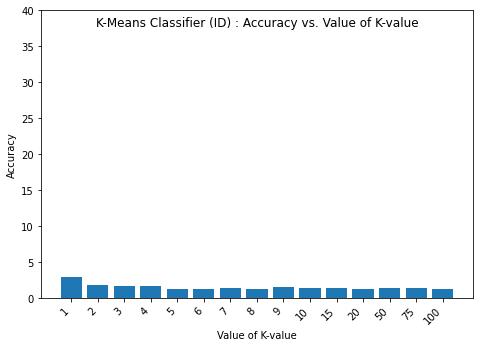

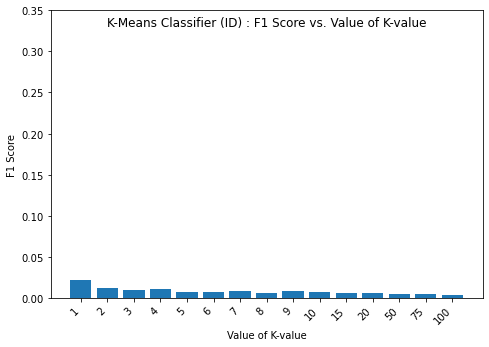

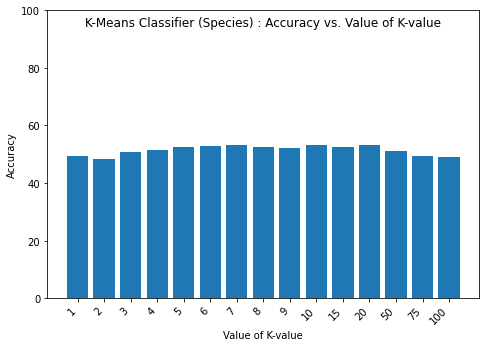

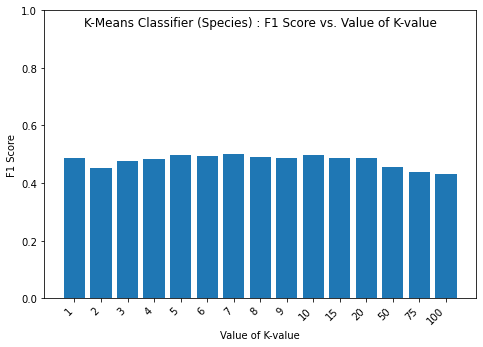

In [8]:
#  K-Nearest Neighbors model
knnmodel = KNeighborsClassifier(n_neighbors=1)

k_values = [1,2,3,4,5,6,7,8,9,10,15,20,50,75,100]
knn_acc = list()
knn_f1_list = list()
knn_species_acc = list()
knn_species_f1_list = list()

for i in tqdm(range(len(k_values))):
    knnmodel = KNeighborsClassifier(n_neighbors=k_values[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    knn_f1_list.append(f1)
    knn_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        knnmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    knn_species_f1_list.append(f1)
    knn_species_acc.append(ac)


plot_scores(k_values, knn_acc, knn_f1_list, "K-value", "Accuracy", "F1 Score", "K-Means Classifier (ID)", True)
plot_scores(k_values, knn_species_acc, knn_species_f1_list, "K-value", "Accuracy", "F1 Score", "K-Means Classifier (Species)", False)

100%|██████████| 9/9 [00:01<00:00,  4.80it/s]


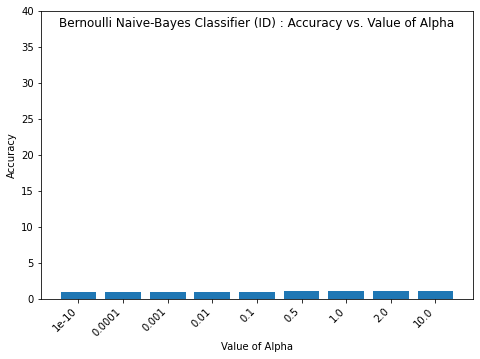

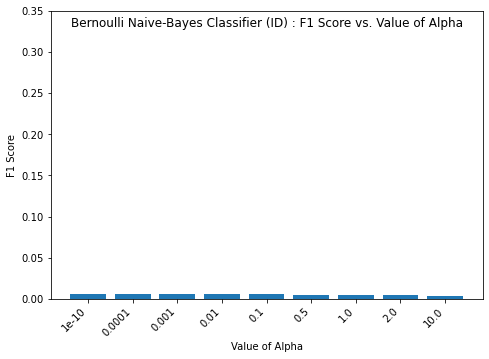

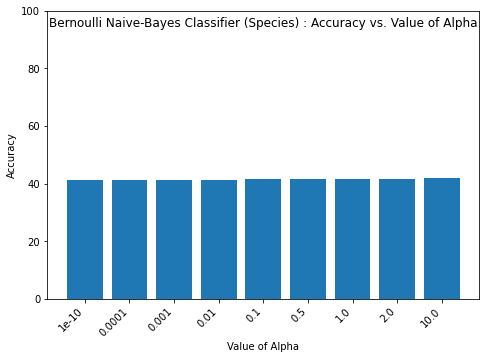

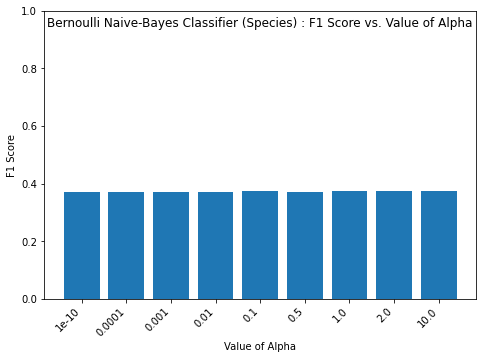

In [9]:
# Bernoulli Naive-Bayes
alpha_list = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
nb_acc = list()
nb_f1_list = list()
nb_species_acc = list()
nb_species_f1_list = list()

for i in tqdm(range(len(alpha_list))):
    nbmodel = BernoulliNB(alpha=alpha_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    nb_f1_list.append(f1)
    nb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        nbmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    nb_species_f1_list.append(f1)
    nb_species_acc.append(ac)

plot_scores(alpha_list, nb_acc, nb_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (ID)", True)
plot_scores(alpha_list, nb_species_acc, nb_species_f1_list, "Alpha", "Accuracy", "F1 Score", "Bernoulli Naive-Bayes Classifier (Species)", False)

100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


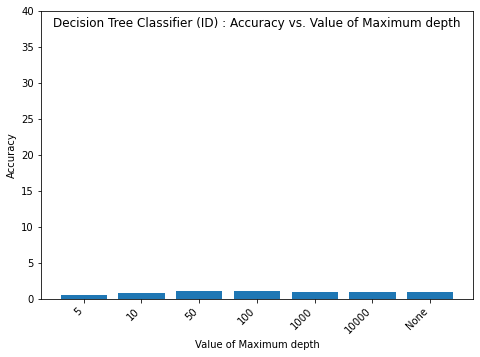

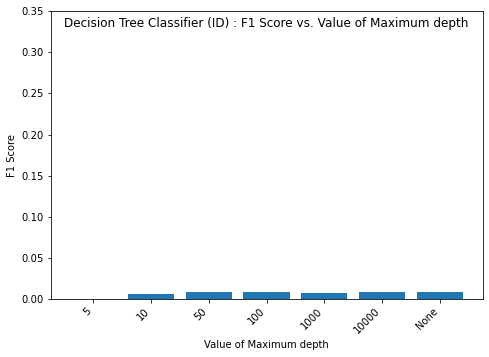

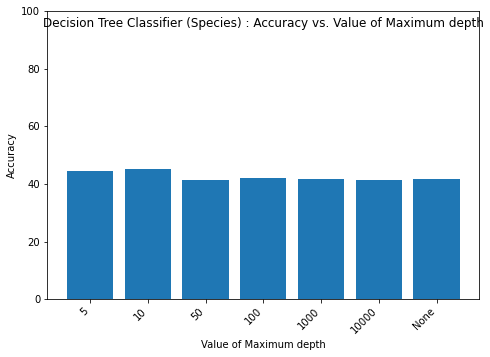

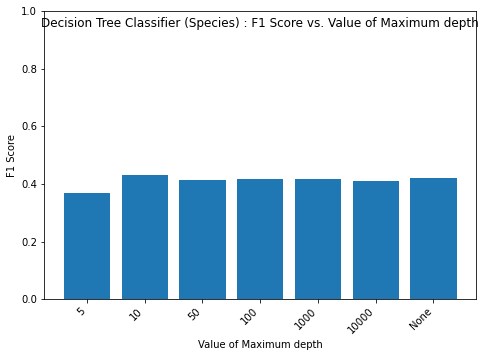

In [10]:
# Decision tree
max_depth_list = [5, 10, 50, 100, 1000, 10000, None]
dt_acc = list()
dt_f1_list = list()
dt_species_acc = list()
dt_species_f1_list = list()
    
for i in tqdm(range(len(max_depth_list))):
    dt = DecisionTreeClassifier(max_depth=max_depth_list[i], criterion='entropy')
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        dt,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    dt_f1_list.append(f1)
    dt_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        dt,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    dt_species_f1_list.append(f1)
    dt_species_acc.append(ac)


plot_scores(max_depth_list, dt_acc, dt_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (ID)", True)
plot_scores(max_depth_list, dt_species_acc, dt_species_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Decision Tree Classifier (Species)", False)

100%|██████████| 7/7 [00:58<00:00,  8.39s/it]


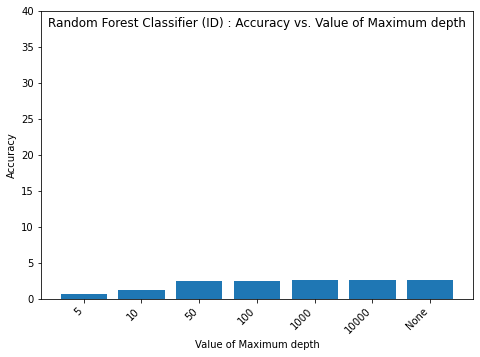

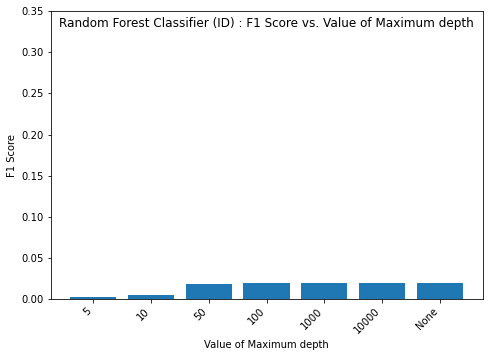

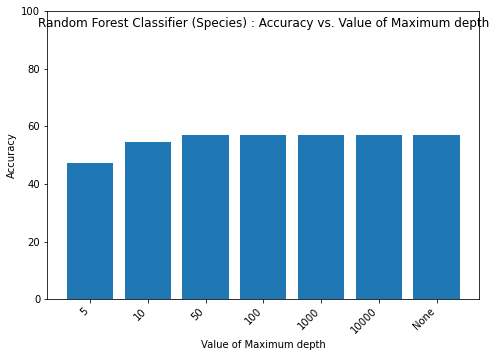

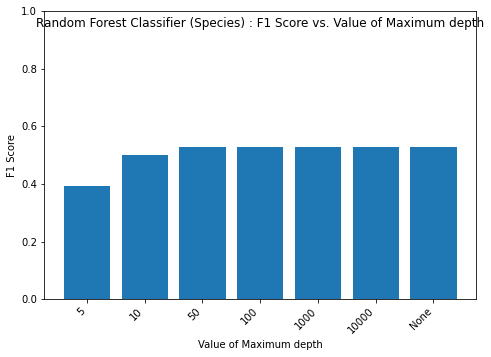

In [11]:
# Random Forest
max_depth_list = [5, 10, 50, 100, 1000, 10000, None]
rf_acc = list()
rf_f1_list = list()
rf_species_acc = list()
rf_species_f1_list = list()
    
for i in tqdm(range(len(max_depth_list))):
    rf_dt = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=max_depth_list[i],
                                       n_estimators=100, oob_score=True)
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        rf_dt,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    rf_f1_list.append(f1)
    rf_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        rf_dt,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    rf_species_f1_list.append(f1)
    rf_species_acc.append(ac)


plot_scores(max_depth_list, rf_acc, rf_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Random Forest Classifier (ID)", True)
plot_scores(max_depth_list, rf_species_acc, rf_species_f1_list, "Maximum depth", "Accuracy", "F1 Score", "Random Forest Classifier (Species)", False)

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


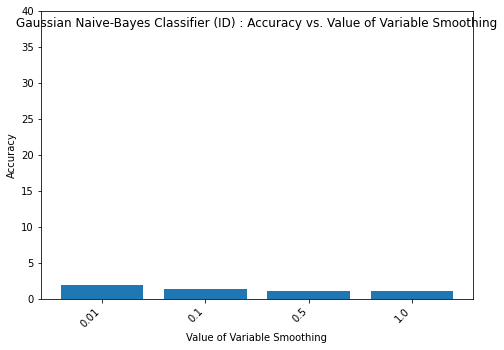

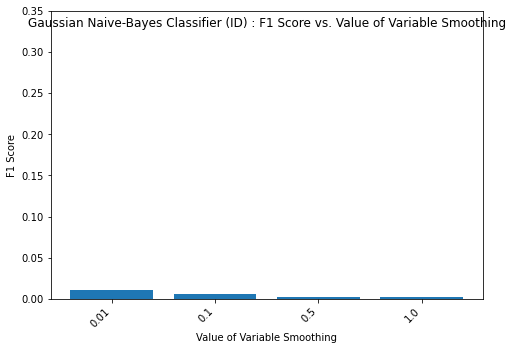

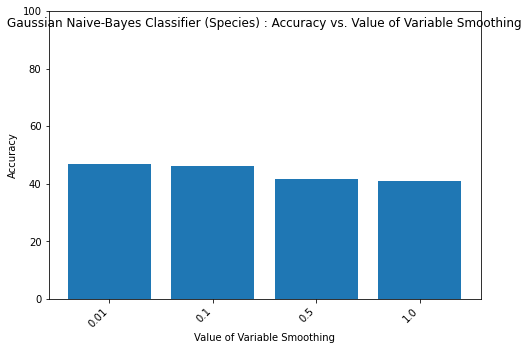

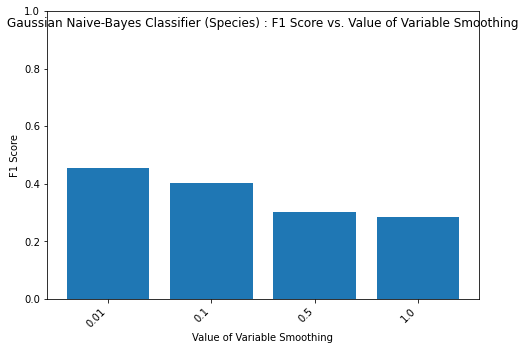

In [12]:
# Gaussian Naive-Bayes
var_smoothing_list = [0.01, 0.1, 0.5, 1.0]
gb_acc = list()
gb_f1_list = list()
gb_species_acc = list()
gb_species_f1_list = list()

for i in tqdm(range(len(var_smoothing_list))):
    gbmodel = GaussianNB(var_smoothing=var_smoothing_list[i])
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    gb_f1_list.append(f1)
    gb_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        gbmodel,
        train_features_pca,
        train_labels,
        test_features_pca,
        test_labels
    )
    
    gb_species_f1_list.append(f1)
    gb_species_acc.append(ac)


plot_scores(var_smoothing_list, gb_acc, gb_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (ID)", True)
plot_scores(var_smoothing_list, gb_species_acc, gb_species_f1_list, "Variable Smoothing", "Accuracy", "F1 Score", "Gaussian Naive-Bayes Classifier (Species)", False)

100%|██████████| 4/4 [02:41<00:00, 40.40s/it]


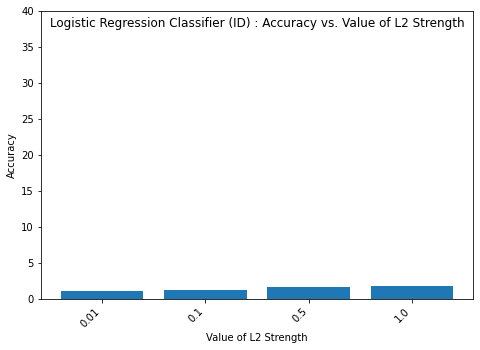

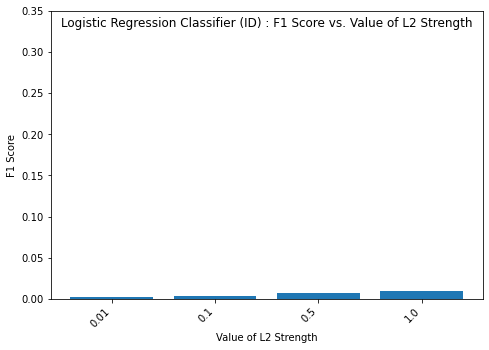

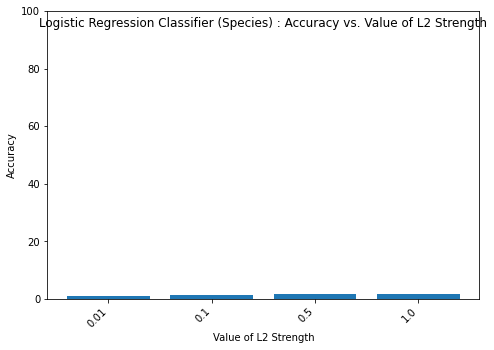

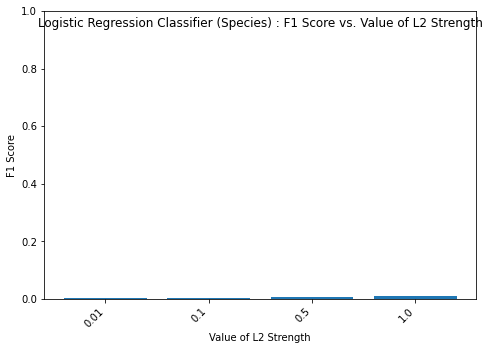

In [13]:
# LogisticRegression
c_list = [0.01, 0.1, 0.5, 1.0]
lr_acc = list()
lr_f1_list = list()
lr_species_acc = list()
lr_species_f1_list = list()
    
for i in tqdm(range(len(c_list))):
    lrmodel = LogisticRegression(C=c_list[i], solver="liblinear", multi_class="auto")
    
    # Test IDs
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    lr_f1_list.append(f1)
    lr_acc.append(ac)
    
    # Test species
    ac,f1 = test_model_accuracy(
        lrmodel,
        train_features_pca,
        train_ids,
        test_features_pca,
        test_ids
    )
    
    lr_species_f1_list.append(f1)
    lr_species_acc.append(ac)


plot_scores(c_list, lr_acc, lr_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (ID)", True)
plot_scores(c_list, lr_species_acc, lr_species_f1_list, "L2 Strength", "Accuracy", "F1 Score", "Logistic Regression Classifier (Species)", False)

100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


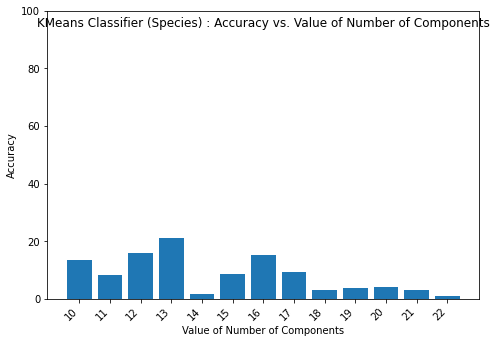

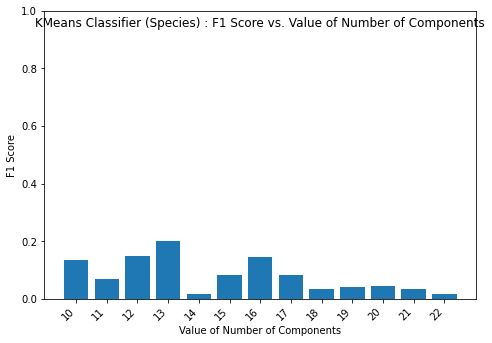

In [14]:
# K-Means clustering
components = [i for i in range(10,23)]
kmeans_acc = list()
kmeans_f1_list = list()
kmeans_species_acc = list()
kmeans_species_f1_list = list()

# K-Means clustering

for i in tqdm(range(len(components))):
    kmeans = KMeans(components[i], random_state=0)
    # Test IDs
    
    ac,f1 = test_cluster_accuracy(kmeans, train_features_pca, test_features_pca)
    
    kmeans_species_f1_list.append(f1)
    kmeans_species_acc.append(ac)


plot_scores(components, kmeans_species_acc, kmeans_species_f1_list, "Number of Components", "Accuracy", "F1 Score", "KMeans Classifier (Species)", False)

100%|██████████| 13/13 [00:30<00:00,  2.36s/it]


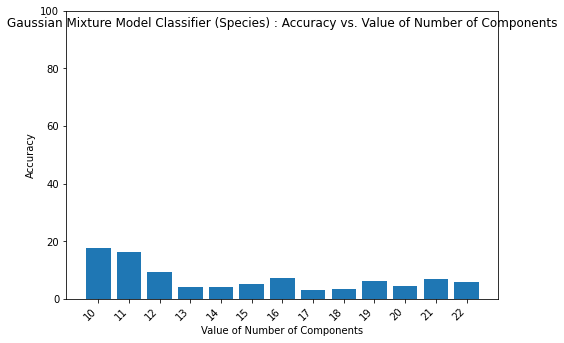

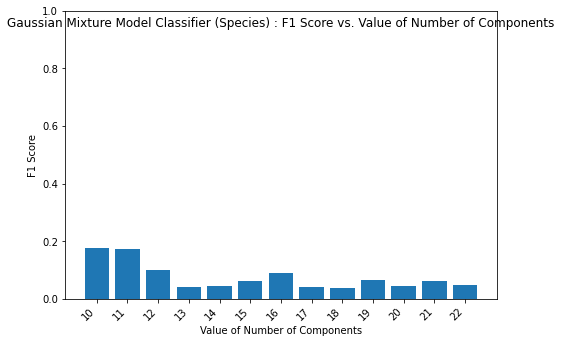

In [15]:
# Gaussian Mixture Model clustering

gmm_acc = list()
gmm_f1_list = list()
gmm_species_acc = list()
gmm_species_f1_list = list()



for i in tqdm(range(len(components))):
    gmm = GMM(n_components=components[i], random_state=0)
    # Test IDs
    
    ac,f1 = test_cluster_accuracy(gmm, train_features_pca, test_features_pca)
    
    gmm_species_f1_list.append(f1)
    gmm_species_acc.append(ac)


plot_scores(components, gmm_species_acc, gmm_species_f1_list, "Number of Components", "Accuracy", "F1 Score", "Gaussian Mixture Model Classifier (Species)", False)

In [16]:
# Neural Network

def create_nn(training_features):
    model = Sequential()
    
    # Input layer
    model.add(Dense(200, input_dim=training_features.shape[1], activation='relu'))
    
    # Hidden Layer
    model.add(Dense(1024, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(512, activation='relu'))
    
    # Hidden Layer
    model.add(Dense(100, activation='relu'))
    
    # Output layer
    model.add(Dense(21, activation='sigmoid')) # 21 possible species

    # Compile the model and calculate its accuracy:
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])     
    
    return model

def test_neural_network(model, training_features, training_labels, testing_features, testing_labels):
    
    # Convert labels to integers
    le = LabelEncoder()
    train_labels_encoded = le.fit_transform(training_labels)
    test_labels_encoded = le.transform(testing_labels)
    
    # Convert train and test labels to one-hot
    enc = OneHotEncoder(handle_unknown='ignore')
    train_labels_onehot = enc.fit_transform(train_labels_encoded.reshape(-1,1)).toarray()
  
    # Fit model
    model.fit(train_features_std, train_labels_onehot, batch_size=32, epochs=40)

    # Predict test labels
    y_predict = model.predict(testing_features)
    
    # Convert prediction output to integer labels
    y_pred_label = list()
    
    # Get index of largest value per row (the predicted label)
    for i in range(y_predict.shape[0]):
        row = y_predict[i]
        y_pred_label.append(np.where(row == np.amax(row))[0][0])
        
    y_pred_label = np.array(y_pred_label)
        
    accuracy = accuracy_score(test_labels_encoded, y_pred_label)*100
    f1 = f1_score(test_labels_encoded, y_pred_label, average="weighted")
    
    return accuracy, f1

model = create_nn(train_features_std)

nn_acc,nn_f1 = test_neural_network(model, train_features_std, train_labels, test_features_std, test_labels)

print("Accuracy: " + str(nn_acc))
print("F1 Score: " + str(nn_f1))


Epoch 1/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.1263 - accuracy: 0.2339
Epoch 2/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0515 - accuracy: 0.3919
Epoch 3/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0420 - accuracy: 0.4254
Epoch 4/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0386 - accuracy: 0.4398
Epoch 5/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0367 - accuracy: 0.4485
Epoch 6/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0355 - accuracy: 0.4576
Epoch 7/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0346 - accuracy: 0.4641
Epoch 8/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0339 - accuracy: 0.4687
Epoch 9/40
5400/5400 [==============================] - 15s 3ms/step - loss: 0.0333 - accuracy: 0.4728
Epoch 10/40
5400/5400 [==============================] - 15s 3ms/step - 

In [21]:
# Hybrid Model

def test_species_to_id_model():
    
    # Traning Phase
    
    # Convert labels to integers
    le = LabelEncoder()
    train_labels_encoded = le.fit_transform(train_labels)
    #test_labels_encoded = le.transform(test_labels)
    train_ids_encoded = le.fit_transform(train_ids)
    test_ids_encoded = le.transform(test_ids)
    
    # Create classifer for species
    rf_species_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=None,
                                       n_estimators=100, oob_score=True)
    
    # Fit species classfier with training features and species labels
    rf_species_classifier.fit(train_features_pca, train_labels_encoded)
    
    # Initialize data and classifier containers per species
    id_classifiers = list()
    species_feature_data = list()
    species_id_data = list()
    for i in range(21):
        id_classifiers.append(RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=None,
                                       n_estimators=100, oob_score=True))
        species_feature_data.append(list())
        species_id_data.append(list())
    
    # Append training data for each species in its designated bin
    for i in range(train_labels_encoded.shape[0]):
        label = train_labels_encoded[i]
        species_feature_data[label].append(train_features_pca[i,:])
        species_id_data[label].append(train_ids_encoded[i])
    
    # Convert all combined training data per predicted species and fit each classfier
    for i in tqdm(range(21)):
        species_feature_data[i] = np.array(species_feature_data[i])
        species_id_data[i] = np.array(species_id_data[i])
        id_classifiers[i].fit(species_feature_data[i], species_id_data[i])
   

    # ID Prediction Phase
    
    id_pred = list()
    for i in tqdm(range(test_features_pca.shape[0])):
        feature_row = test_features_pca[i,:].reshape(1, -1)
        
        # Predict the species
        species_pred = rf_species_classifier.predict(feature_row)[0]
        
        # Predict the ID based on the predicted species model
        id_prediction = id_classifiers[species_pred].predict(feature_row)[0]
        
        id_pred.append(id_prediction)
        
    # Convert output to array
    id_pred = np.array(id_pred)
    
    # Compute Results
    accuracy = accuracy_score(test_ids_encoded, id_pred)*100
    f1 = f1_score(test_ids_encoded, id_pred, average="weighted")
    return accuracy, f1 
    
hybrid_acc, hybrid_f1 = test_species_to_id_model()

print("Accuracy: " + str(hybrid_acc))
print("F1 Score: " + str(hybrid_f1))

100%|██████████| 1350/1350 [04:52<00:00,  4.62it/s]

Accuracy: 2.5185185185185186
F1 Score: 0.017728395061728394


In [22]:
# Prepare compilation

result_labels_id = ["kNN", "BernoulliNB", "Decision Tree", "Random Forest", "GaussianNB", "Logistic Regression", "Hybrid Model"]
result_labels_species = ["kNN", "BernoulliNB", "Decision Tree", "Random Forest", "GaussianNB",
                         "Logistic Regression", "K-Means", "Gaussian Mixture Model", "Neural Network"]


id_accuracies = list()
id_accuracies.append(max(knn_acc))
id_accuracies.append(max(nb_acc))
id_accuracies.append(max(dt_acc))
id_accuracies.append(max(rf_acc))
id_accuracies.append(max(gb_acc))
id_accuracies.append(max(lr_acc))
id_accuracies.append(hybrid_acc)

id_f1s = list()
id_f1s.append(max(knn_f1_list))
id_f1s.append(max(nb_f1_list))
id_f1s.append(max(dt_f1_list))
id_f1s.append(max(rf_f1_list))
id_f1s.append(max(gb_f1_list))
id_f1s.append(max(lr_f1_list))
id_f1s.append(hybrid_f1)


id_species_accuracies = list()
id_species_accuracies.append(max(knn_species_acc))
id_species_accuracies.append(max(nb_species_acc))
id_species_accuracies.append(max(dt_species_acc))
id_species_accuracies.append(max(rf_species_acc))
id_species_accuracies.append(max(gb_species_acc))
id_species_accuracies.append(max(lr_species_acc))
id_species_accuracies.append(max(kmeans_species_acc))
id_species_accuracies.append(max(gmm_species_acc))
id_species_accuracies.append(nn_acc)

id_species_f1s = list()
id_species_f1s.append(max(knn_species_f1_list))
id_species_f1s.append(max(nb_species_f1_list))
id_species_f1s.append(max(dt_species_f1_list))
id_species_f1s.append(max(rf_species_f1_list))
id_species_f1s.append(max(gb_species_f1_list))
id_species_f1s.append(max(lr_species_f1_list))
id_species_f1s.append(max(kmeans_species_f1_list))
id_species_f1s.append(max(gmm_species_f1_list))
id_species_f1s.append(nn_f1)


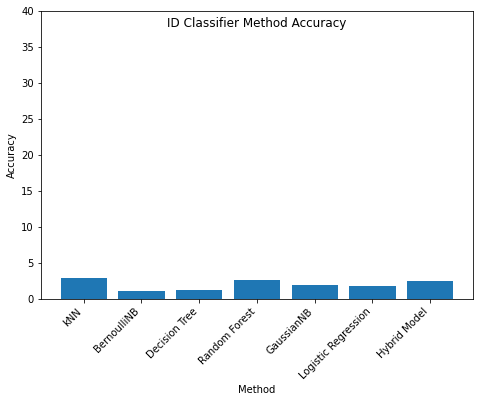

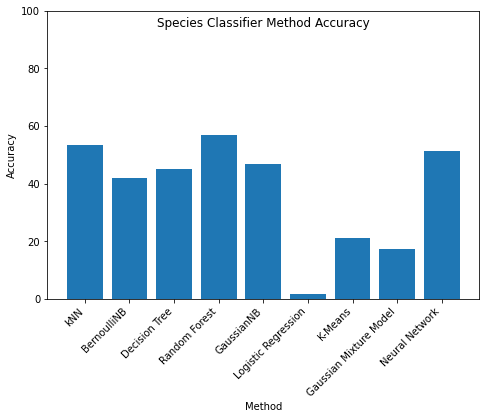

In [23]:
# Plot Accuracies
fig = plt.figure()
fig.suptitle("ID Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,40)
ax.bar(result_labels_id, id_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier Method Accuracy")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,100)
ax.bar(result_labels_species, id_species_accuracies)
plt.xticks(rotation=45, ha='right')
plt.show()

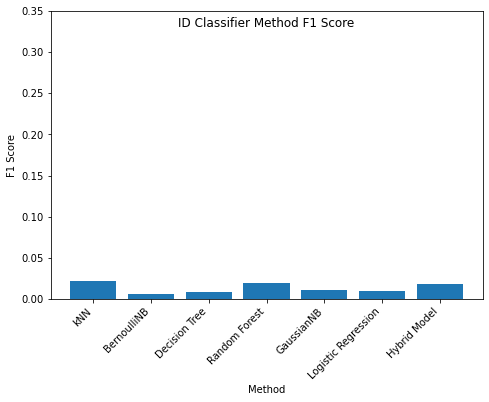

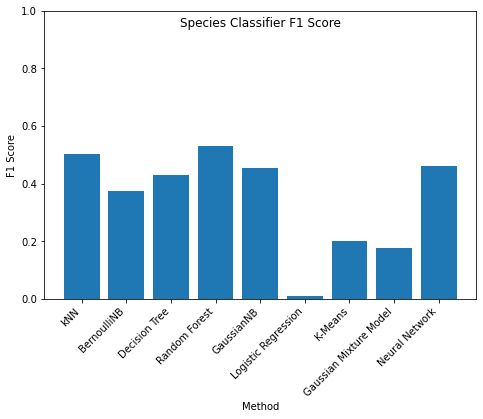

In [24]:
# Plot F1 scores
fig = plt.figure()
fig.suptitle("ID Classifier Method F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,0.35)
ax.bar(result_labels_id, id_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()

fig = plt.figure()
fig.suptitle("Species Classifier F1 Score")
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Method")
ax.set_ylabel("F1 Score")
ax.set_ylim(0,1)
ax.bar(result_labels_species, id_species_f1s)
plt.xticks(rotation=45, ha='right')
plt.show()